## Clase 3a. Clasificacion y  Ensambles

In [1]:
import pandas as pd

# Import numpy
import numpy as np
import seaborn as sns
# Import matplotlib for graphs, set inline
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
# Import datasets for use
from sklearn import datasets

# Visualizacion de datos

In [2]:
iris = datasets.load_iris()
iris_df= pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["class"]=iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   class              150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


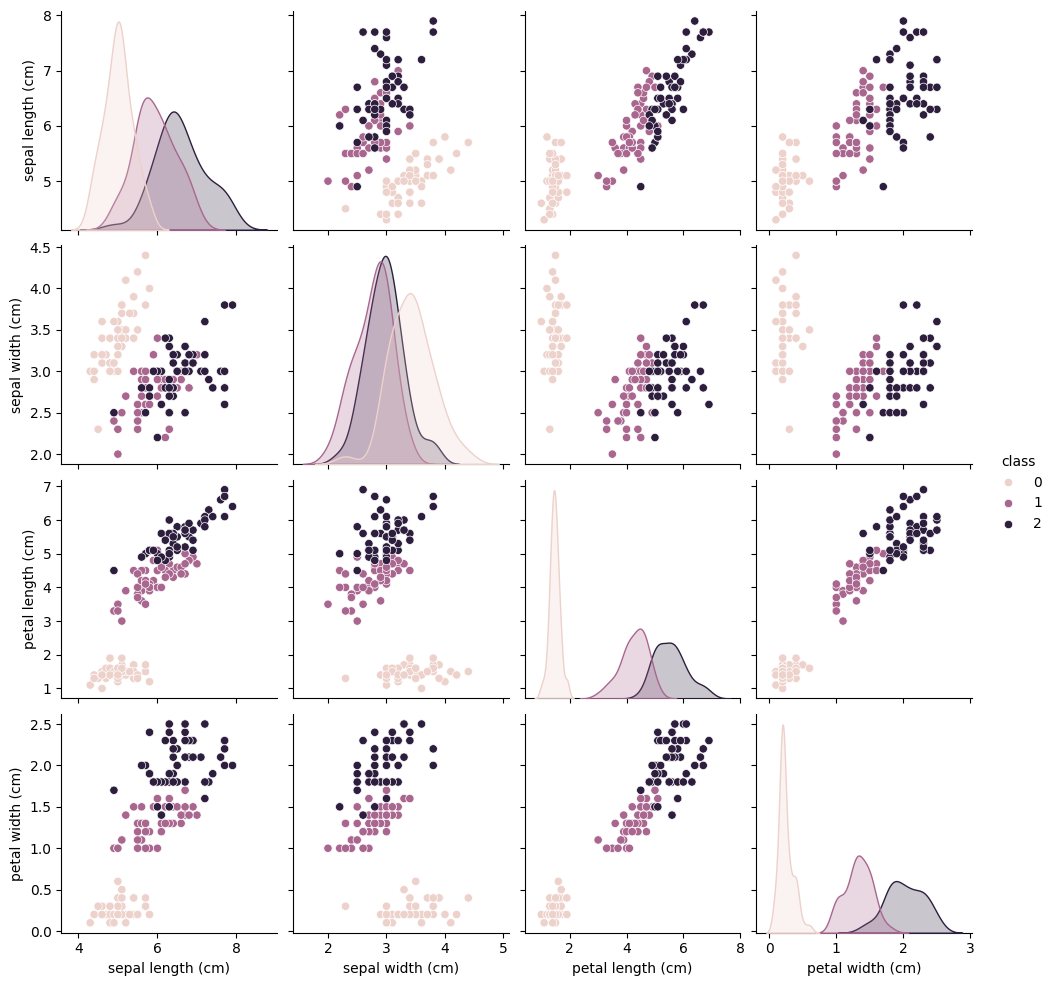

In [4]:
g= sns.pairplot(iris_df, hue='class',kind="scatter")

<Axes: >

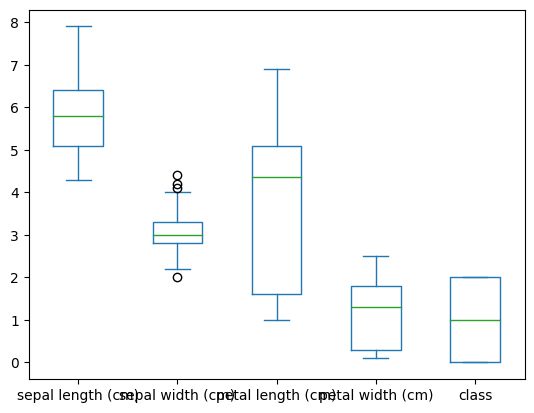

In [5]:
iris_df.plot(kind='box')

In [3]:
y= iris_df['class']
X=iris_df.drop('class',axis=1)
features_num=["sepal length (cm)","petal length (cm)","petal width (cm)"]
features_num_outlier= ["sepal width (cm)"]
X =X[features_num_outlier+features_num]

# Split de datos entrenamiento  80%, test 20%

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

# Preprocesamiento y Feature Engineering

In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
class NumericalIQscaler(BaseEstimator,TransformerMixin):
    def __init__(self, columns):
        self.columns=columns
        self._scaler = RobustScaler()
        return None
    
    def fit(self, X,y=None):
      
        X = self._scaler.fit(X)
        return self
    
    def remover_outlier(self, X):
        x= pd.DataFrame(X,columns=self.columns)

        for col in x.columns:
            Q1= x[col].quantile(0.25)
            Q3= x[col].quantile(0.75)
            IQR= Q3-Q1
            low= Q1 -1.5*IQR
            high= Q1+1.5*IQR

            x[col] = np.where(x[col]<low,low,x[col])
            x[col] = np.where(x[col]>high, high,x[col])
        return x
    def transform(self, X):
        #X=> dataframe => X.columns, X.index, X.head(), X.sample() 
        X =self.remover_outlier(X)
        X=pd.DataFrame(self._scaler.transform(X),columns=X.columns,index=X.index)
        return X

In [7]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [8]:
X_train.columns

Index(['sepal width (cm)', 'sepal length (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [9]:
#En este primero se hace un pipeline para la variable con outliers
preprocessor_robust = ColumnTransformer(
    transformers=[
     ("robust", NumericalIQscaler(columns=features_num_outlier), features_num_outlier )   
    ]
)

#En este segundo se hace la estandarización para las demás variables que en el boxplot no se ven outliers
preprocessor_num= ColumnTransformer(
transformers=[
    ("transf. num", StandardScaler(), features_num )
]

)

preprocessor_union = FeatureUnion(

    transformer_list=[
        ("robust_column",preprocessor_robust ),
        ("scaler numerical", preprocessor_num)
    ]
)

In [13]:
preprocessor_union

FeatureUnion(transformer_list=[('robust_column',
                                ColumnTransformer(transformers=[('robust',
                                                                 NumericalIQscaler(columns=['sepal '
                                                                                            'width '
                                                                                            '(cm)']),
                                                                 ['sepal width '
                                                                  '(cm)'])])),
                               ('scaler numerical',
                                ColumnTransformer(transformers=[('transf. num',
                                                                 StandardScaler(),
                                                                 ['sepal '
                                                                  'length (cm)',
                                                                  'petal '
                                                                  'length (cm)',
                                                                  'petal width '
                                                                  '(cm)'])]))])

# Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
pipelineLR =Pipeline(
    steps=[
        ("preprocesamiento",preprocessor_union),
        ("LogisticRegression", LogisticRegression())
    ])

In [16]:
pipelineLR

Pipeline(steps=[('preprocesamiento',
                 FeatureUnion(transformer_list=[('robust_column',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('scaler numerical',
                                                 ColumnTransformer(transformers=[('transf. '
                                                                                  'num',
                                                                                  StandardScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('LogisticRegression', LogisticRegression())])

In [12]:
modelLR = pipelineLR.fit(X_train,y_train)

In [13]:
modelLR.score(X_test,y_test)

0.9666666666666667

In [14]:
predictLR = modelLR.predict(X_test)

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [16]:
class_report_LR = classification_report(y_test,predictLR )
print(class_report_LR)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92         6
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



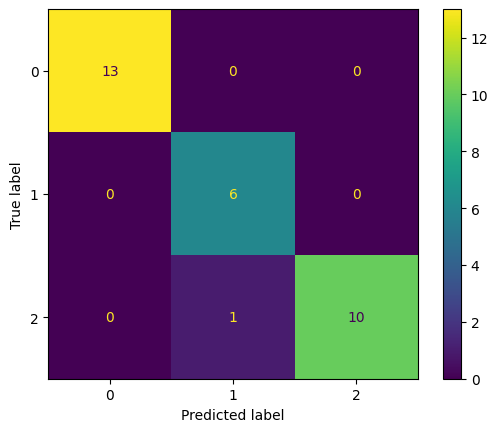

In [22]:
ConfusionMatrixDisplay.from_estimator(modelLR, X_test,y_test)

In [17]:
from sklearn.metrics import RocCurveDisplay 
from sklearn import preprocessing

In [18]:
#La curva ROC es cuando es clasificación binaria, en este caso como es multiclase se aplicará LabelBinazizer donde coloca una clase como 0 y las otras dos clases como 1
lb = preprocessing.LabelBinarizer()
y_test_lb = lb.fit_transform(y_test) #Se applica solo a test porque se está evaluando el resultado del modelo, no para entrenamiento

In [19]:
y_test_lb[:5]

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

In [26]:
y_test[:5]

72     1
112    2
132    2
88     1
37     0
Name: class, dtype: int32

In [20]:
predictLR_lb = lb.transform(predictLR)

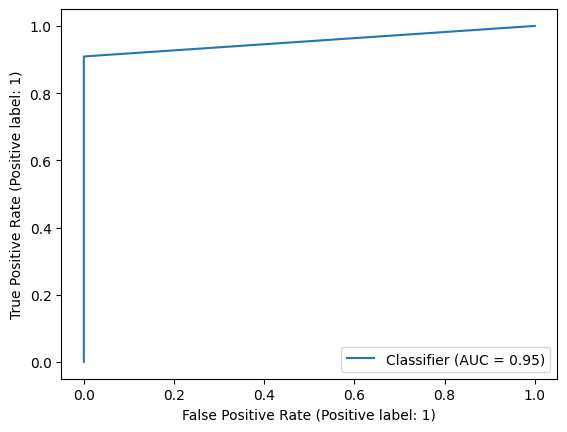

In [21]:
class_num=2 #La clase que se desea mirar, en este caso la clase 2
RocCurveDisplay.from_predictions(y_test_lb[:,class_num],
predictLR_lb[:,class_num]
)


# Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB #Se asume que cada atributo es independiente, Naive Bayes es el producto de los atributos
from sklearn.model_selection import cross_val_score
GNB =GaussianNB()

In [23]:
score = cross_val_score(GNB,X_train,y_train,cv=5)
#GNB.fit(X_train,y_train) sin hacerle cross validation

Text(0.5, 1.0, ' valor promedio del accuracy: 0.95')

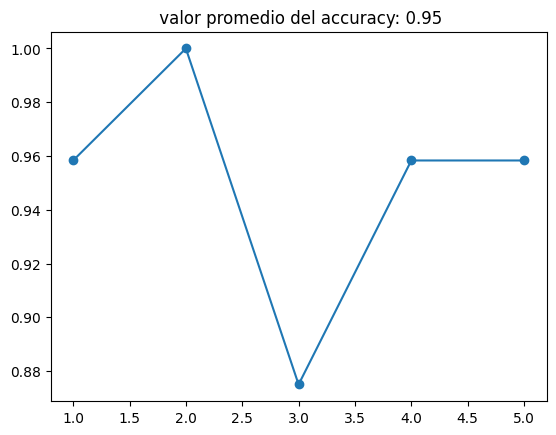

In [24]:
folds= np.array(range(1,6))
plt.scatter(folds,score)
plt.plot(folds,score)
plt.title(f" valor promedio del accuracy: {score.mean()}")

# Arboles de decision

In [25]:
from sklearn import tree

In [26]:
pipelinetree = Pipeline(
    steps=[
        ("preprocessing",preprocessor_union),
        ('tree', tree.DecisionTreeClassifier(criterion='entropy'))
    ]
)

In [27]:
modeltree =pipelinetree.fit(X_train,y_train)

In [28]:
modeltree

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('robust_column',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('scaler numerical',
                                                 ColumnTransformer(transformers=[('transf. '
                                                                                  'num',
                                                                                  StandardScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('tree', DecisionTreeClassifier(criterion='entropy'))])

[Text(0.5, 0.9166666666666666, 'petal width (cm) <= -0.575\nentropy = 1.581\nsamples = 120\nvalue = [37, 44, 39]\nclass = versicolor'),
 Text(0.4230769230769231, 0.75, 'entropy = 0.0\nsamples = 37\nvalue = [37, 0, 0]\nclass = setosa'),
 Text(0.5769230769230769, 0.75, 'petal width (cm) <= 0.712\nentropy = 0.997\nsamples = 83\nvalue = [0, 44, 39]\nclass = versicolor'),
 Text(0.3076923076923077, 0.5833333333333334, 'petal length (cm) <= 0.656\nentropy = 0.42\nsamples = 47\nvalue = [0, 43, 4]\nclass = versicolor'),
 Text(0.15384615384615385, 0.4166666666666667, 'petal width (cm) <= 0.577\nentropy = 0.162\nsamples = 42\nvalue = [0, 41, 1]\nclass = versicolor'),
 Text(0.07692307692307693, 0.25, 'entropy = 0.0\nsamples = 41\nvalue = [0, 41, 0]\nclass = versicolor'),
 Text(0.23076923076923078, 0.25, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = virginica'),
 Text(0.46153846153846156, 0.4166666666666667, 'petal length (cm) <= 0.888\nentropy = 0.971\nsamples = 5\nvalue = [0, 2, 3]\ncla

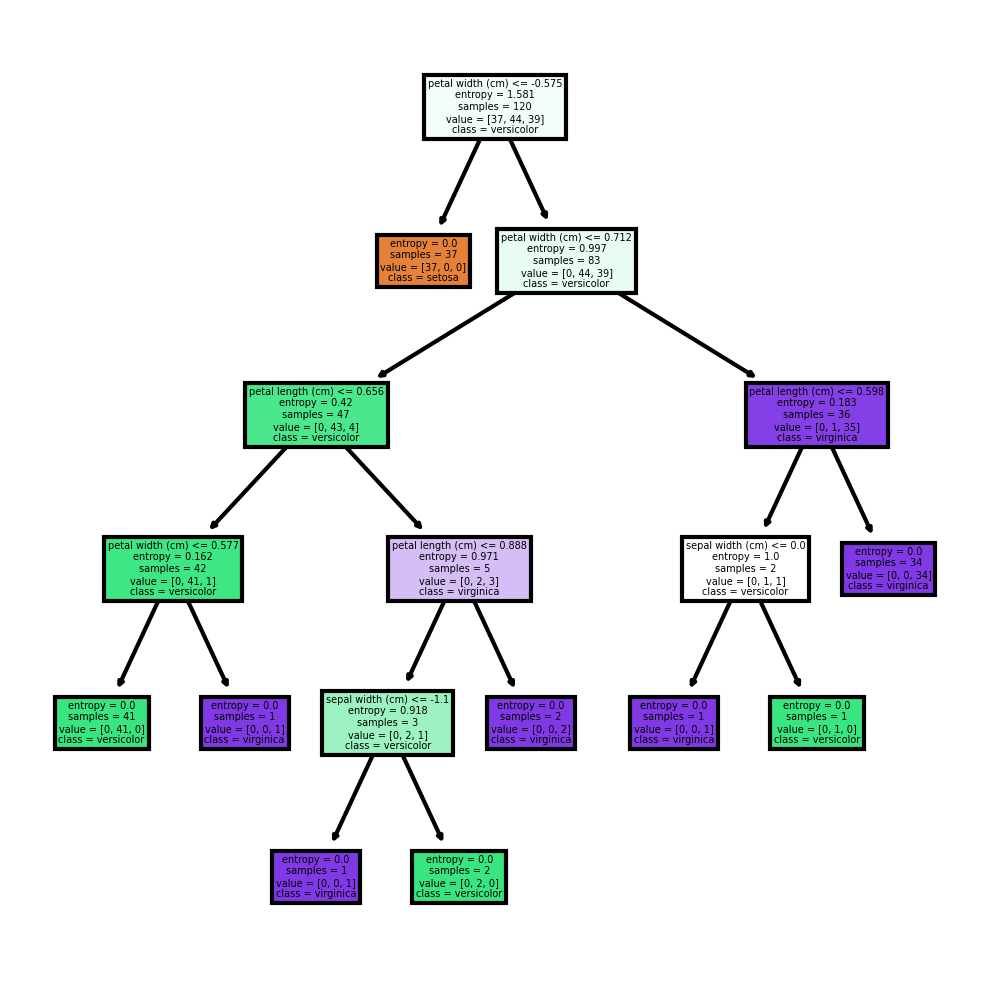

In [29]:
fig, axis =plt.subplots(nrows =1, ncols=1, figsize=(4,4),dpi=300)
fn = features_num_outlier+features_num
cn=  ['setosa', 'versicolor', 'virginica']
tree.plot_tree(pipelinetree["tree"],feature_names=fn, class_names=cn,filled=True ) #Del pipeline se extrae solo el modelo -> pipelinetree["tree"]
#Aquí se debe evaluar si el modelo da sobreajuste, en tal caso mirar si se poda o se determina la profundidad del árbol

In [30]:
texttree= tree.export_text(pipelinetree['tree'])
print(texttree)

|--- feature_3 <= -0.57
|   |--- class: 0
|--- feature_3 >  -0.57
|   |--- feature_3 <= 0.71
|   |   |--- feature_2 <= 0.66
|   |   |   |--- feature_3 <= 0.58
|   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  0.58
|   |   |   |   |--- class: 2
|   |   |--- feature_2 >  0.66
|   |   |   |--- feature_2 <= 0.89
|   |   |   |   |--- feature_0 <= -1.10
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_0 >  -1.10
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  0.89
|   |   |   |   |--- class: 2
|   |--- feature_3 >  0.71
|   |   |--- feature_2 <= 0.60
|   |   |   |--- feature_0 <= 0.00
|   |   |   |   |--- class: 2
|   |   |   |--- feature_0 >  0.00
|   |   |   |   |--- class: 1
|   |   |--- feature_2 >  0.60
|   |   |   |--- class: 2



In [ ]:
#!pip install graphviz
import graphviz
import os
#os.environ["PATH"] += os.pathsep + 'C:\Users\javier\miniconda3\envs\py10\Lib\site-packages\graphviz\'

treedata= tree.export_graphviz( pipelinetree["tree"],feature_names=fn, class_names=cn,filled=True)
graph = graphviz.Source(treedata)
graph

In [32]:
#!pip install dtreeviz
import dtreeviz




viz = dtreeviz.model(pipelinetree["tree"],X_train= X_test,y_train=y_test, target_name='class', feature_names=fn, class_names=cn)

#viz.view()

In [33]:
print(X_test.iloc[1],cn[y_test.iloc[1]])

sepal width (cm)     3.0
sepal length (cm)    6.8
petal length (cm)    5.5
petal width (cm)     2.1
Name: 112, dtype: float64 virginica


In [ ]:
#viz.view(x=X_test.iloc[1])

c:\Users\Usuario Autorizado\AppData\Local\Programs\Python\Python312\Lib\site-packages\dtreeviz\models\shadow_decision_tree.py:335: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


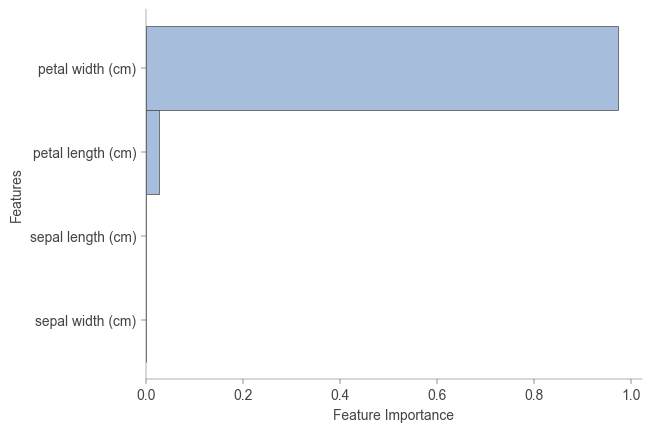

In [34]:
#feature_importance dice qué atributos son los más importantes para la predicción por registro, en este caso el registro 0
viz.instance_feature_importance(X_test.iloc[0])

Los árboles de decisión no solo sirve para la predicción, sino también para el preprocesamiento de los datos para saber la importancia de los atributos

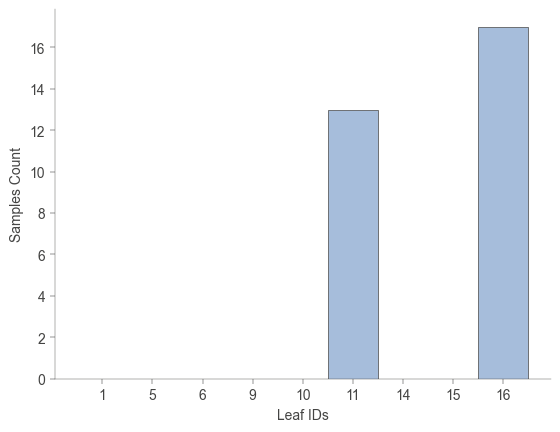

In [35]:
viz.leaf_sizes()

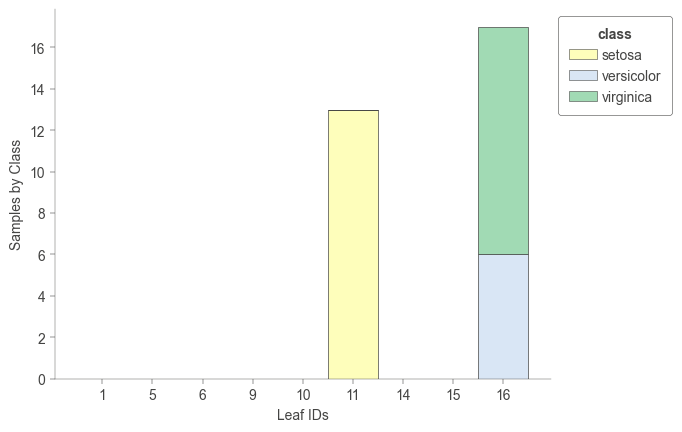

In [36]:
viz.ctree_leaf_distributions()

In [37]:
viz.node_stats(node_id=2)

,sepal width (cm),sepal length (cm),petal length (cm),petal width (cm)
count,30.0,30.0,30.0,30.0
mean,3.123333,5.74,3.506667,1.1
std,0.41745,0.893115,1.914362,0.846901
min,2.3,4.3,1.1,0.1
25%,2.9,5.125,1.4,0.2
50%,3.0,5.55,4.25,1.3
75%,3.4,6.3,5.05,1.8
max,4.2,7.7,6.7,2.3


In [38]:
importances = modeltree['tree'].feature_importances_

In [39]:
col_importances= pd.Series(importances, index=features_num_outlier+features_num)

<Axes: >

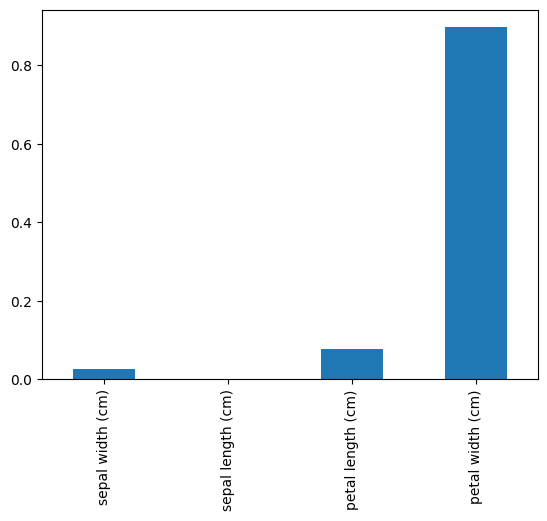

In [40]:
#Variables más importantes para toda la base de datos
fig, ax = plt.subplots()
col_importances.plot.bar(ax=ax)

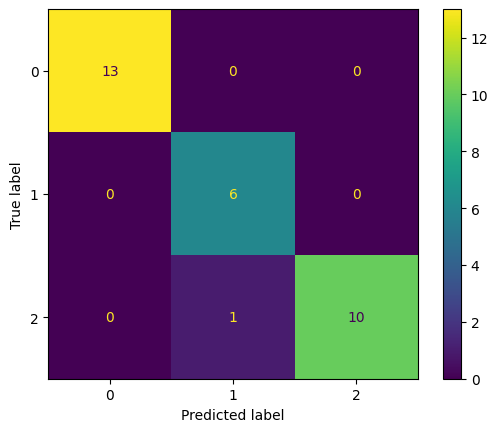

In [41]:
ConfusionMatrixDisplay.from_estimator(modeltree, X_test,y_test)

In [42]:
predicttree=modeltree.predict(X_test)

In [43]:
print(classification_report(y_test,predicttree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92         6
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



# SVM

In [44]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [45]:
pipelinesvm = Pipeline(
    steps=[
     ("preprocessing", preprocessor_union),
     ('svm', svm.SVC())  #El SVC es porque es de clasificación
    ]
)

parasmsvm= [
    {
       "svm__C":[0.9,0.1,0.8,1.1],
       "svm__kernel":["linear", "poly", "rbf"] 
    }
]

gs_svm = GridSearchCV(estimator=pipelinesvm,param_grid=parasmsvm,cv=10,scoring="accuracy")

In [46]:
modelsvm = gs_svm.fit(X_train,y_train)

In [47]:
modelsvm

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        FeatureUnion(transformer_list=[('robust_column',
                                                                        ColumnTransformer(transformers=[('robust',
                                                                                                         NumericalIQscaler(columns=['sepal '
                                                                                                                                    'width '
                                                                                                                                    '(cm)']),
                                                                                                         ['sepal '
                                                                                                          'width '
                                                                                                          '(cm)'])])),
                                                                       ('scaler '
                                                                        'numerical',
                                                                        ColumnTransformer(transformers=[('transf. '
                                                                                                         'num',
                                                                                                         StandardScaler(),
                                                                                                         ['sepal '
                                                                                                          'length '
                                                                                                          '(cm)',
                                                                                                          'petal '
                                                                                                          'length '
                                                                                                          '(cm)',
                                                                                                          'petal '
                                                                                                          'width '
                                                                                                          '(cm)'])]))])),
                                       ('svm', SVC())]),
             param_grid=[{'svm__C': [0.9, 0.1, 0.8, 1.1],
                          'svm__kernel': ['linear', 'poly', 'rbf']}],
             scoring='accuracy')

In [48]:
print(modelsvm.best_params_,modelsvm.best_score_,modelsvm.score(X_test,y_test))

{'svm__C': 0.1, 'svm__kernel': 'linear'} 0.9833333333333332 0.9


In [49]:
predictSVM= modelsvm.predict(X_test)

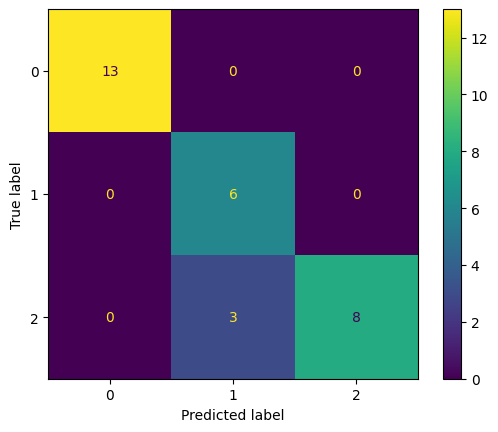

In [50]:
ConfusionMatrixDisplay.from_estimator(modelsvm,X_test,y_test)

In [51]:
print(classification_report(y_test,predictSVM))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.67      1.00      0.80         6
           2       1.00      0.73      0.84        11

    accuracy                           0.90        30
   macro avg       0.89      0.91      0.88        30
weighted avg       0.93      0.90      0.90        30



In [52]:
from sklearn.feature_selection import SelectKBest, f_regression

clf= svm.SVC(kernel='linear')
anova_filter =SelectKBest(f_regression,k=2)

In [53]:
anomesvm =make_pipeline(
preprocessor_union,
anova_filter,
clf
)

In [54]:
anomesvm

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('robust_column',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('scaler numerical',
                                                 ColumnTransformer(transformers=[('transf. '
                                                                                  'num',
                                                                                  StandardScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('selectkbest',
                 SelectKBest(k=2,
                             score_func=<function f_regression at 0x000001B58BCE5800>)),
                ('svc', SVC(kernel='linear'))])

In [55]:
anomesvm.fit(X_train,y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('robust_column',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('scaler numerical',
                                                 ColumnTransformer(transformers=[('transf. '
                                                                                  'num',
                                                                                  StandardScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('selectkbest',
                 SelectKBest(k=2,
                             score_func=<function f_regression at 0x000001B58BCE5800>)),
                ('svc', SVC(kernel='linear'))])

In [56]:
predict_an_svm= anomesvm.predict(X_test)

In [57]:
print(classification_report(y_test,predict_an_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92         6
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



In [58]:
anomesvm[-2].pvalues_

array([8.43110252e-06, 7.71224832e-25, 5.14314543e-60, 3.87939632e-62])

In [59]:
anomesvm[-2].scores_

array([  21.70080379,  172.54567158, 1024.70619844, 1123.29689249])

# KNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier

pipelineknn = make_pipeline(
    preprocessor_union,
    KNeighborsClassifier()
)

paramsknn = [
{

'kneighborsclassifier__n_neighbors': [3,5,7],
'kneighborsclassifier__p': list(range(1,5))

}

]

gs_knn =GridSearchCV(estimator=pipelineknn,param_grid=paramsknn,cv=5, scoring='accuracy')
modelknn =gs_knn.fit(X_train,y_train)


In [61]:
print(modelknn.best_params_,modelknn.best_score_,modelknn.score(X_test,y_test))

{'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 2} 0.9666666666666668 0.9333333333333333


In [62]:
predictknn= modelknn.predict(X_test)

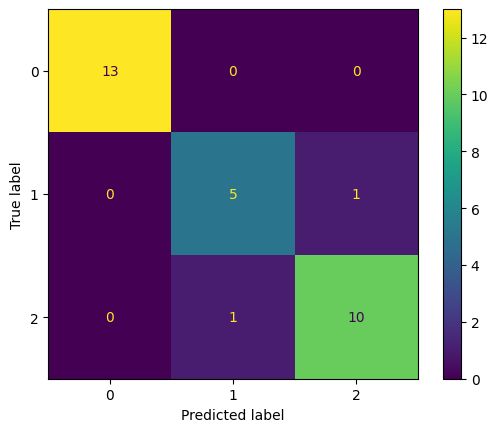

In [63]:
ConfusionMatrixDisplay.from_estimator(modelknn,X_test,y_test)

In [64]:
print(classification_report(y_test,predictknn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.83      0.83      0.83         6
           2       0.91      0.91      0.91        11

    accuracy                           0.93        30
   macro avg       0.91      0.91      0.91        30
weighted avg       0.93      0.93      0.93        30



In [65]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

In [66]:
knn_= KNeighborsClassifier(n_neighbors=5, p=2)
scoreknn = knn_.fit(X_train.iloc[:,2:],y_train)

c:\Users\Diana.Forero\Anaconda3\envs\pruebas\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
C:\Users\Diana.Forero\AppData\Local\Temp\ipykernel_22936\692407483.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


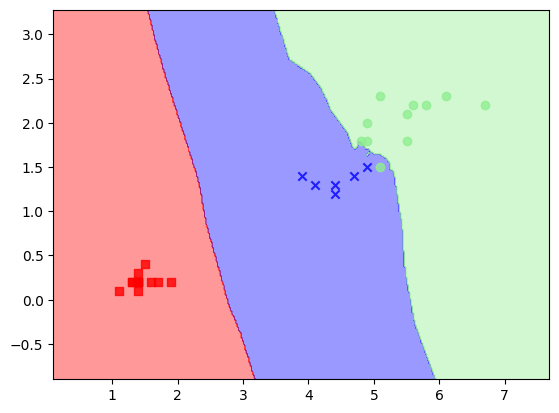

In [ ]:
plot_decision_regions(X_test.iloc[:,2:].values,y_test.values,scoreknn)

# Redes neuronales

In [67]:
from sklearn.neural_network  import MLPClassifier

In [69]:
pipelinenn= Pipeline(
steps=[
    ('preprocessing', preprocessor_union),
    ("estimador", KNeighborsClassifier(n_neighbors=3,p=2))
]
)

######## SE CORREN LOS DIFERENTES MODELOS #######################
params_grid=[
{
'estimador':[KNeighborsClassifier()],
 "estimador__n_neighbors": [2,4,8,9],
 "estimador__p":[1,4,5,6]
},
{
'estimador':[MLPClassifier(learning_rate='constante')],
"estimador__hidden_layer_sizes": list(range(10,500,100)),
"estimador__activation": ["logistic","relu","tanh"]
},
{
'estimador':[MLPClassifier(learning_rate='adaptive')],
"estimador__hidden_layer_sizes": list(range(10,500,100)),
"estimador__activation": ["logistic","relu","tanh"]
},

{"estimador": [svm.SVC()],
"estimador__C":[0.9,0.1,0.8,1.1],
"estimador__kernel":["linear", "poly", "rbf"] 

}


]



In [70]:
gridnn =GridSearchCV(pipelinenn,param_grid=params_grid, cv=5, scoring="accuracy")

In [71]:
modelmlp = gridnn.fit(X_train,y_train)

c:\Users\Usuario Autorizado\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
c:\Users\Usuario Autorizado\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
c:\Users\Usuario Autorizado\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
c:\Users\Usuario Autorizado\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opt

In [72]:
modelmlp.best_estimator_

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('robust_column',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('scaler numerical',
                                                 ColumnTransformer(transformers=[('transf. '
                                                                                  'num',
                                                                                  StandardScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('estimador',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=410,
                               learning_rate='adaptive'))])

In [73]:
modelmlp.best_params_

{'estimador': MLPClassifier(learning_rate='adaptive'),
 'estimador__activation': 'tanh',
 'estimador__hidden_layer_sizes': 410}

In [74]:
modelmlp.best_score_

0.975

## Ensambles

![image.png](https://machinelearningmastery.com/wp-content/uploads/2020/11/Bagging-Ensemble.png)
![image.png](https://machinelearningmastery.com/wp-content/uploads/2020/11/Stacking-Ensemble.png)

![image.png](https://machinelearningmastery.com/wp-content/uploads/2020/11/Boosting-Ensemble.png)

## Bagging. Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

rfc_200= RandomForestClassifier(n_estimators=200, random_state=0)
rfc_200.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [76]:
predict_rf200= rfc_200.predict(X_test)

In [77]:
print(classification_report(y_test,predict_rf200))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.75      1.00      0.86         6
           2       1.00      0.82      0.90        11

    accuracy                           0.93        30
   macro avg       0.92      0.94      0.92        30
weighted avg       0.95      0.93      0.93        30



In [78]:
rfc_200.score(X_test,y_test)

0.9333333333333333

In [79]:
importance_rf200 =rfc_200.feature_importances_

In [80]:
features_score = pd.Series(importance_rf200 , index=X_train.columns).sort_values(ascending=False)

<Axes: xlabel='None', ylabel='None'>

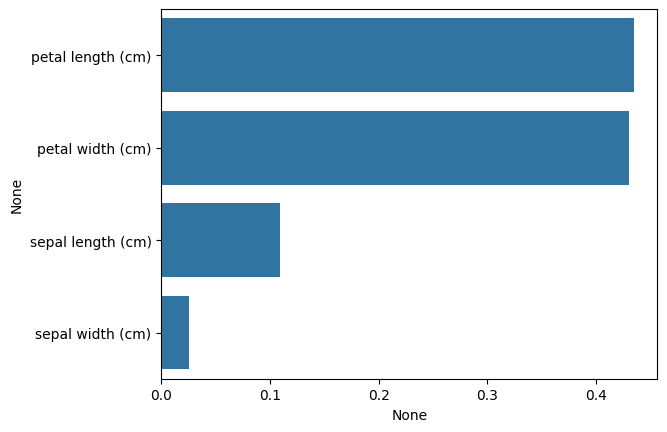

In [81]:
sns.barplot(x= features_score,y=features_score.index)

<h4> SHAP PARA ENTENDER LA EXPLICAICÓN DEL MODELO <h2>

In [2]:
pip install shap

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/448.0 kB ? eta -:--:--
   ----------------------- ---------------- 266.2/448.0 kB 8.0 MB/s eta 0:00:01
   ---------------------------------------  440.3/448.0 kB 5.5 MB/s eta 0:00:01
   ---------------------------------------- 448.0/448.0 kB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------------------- 78.3/78.3 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ------------ --------------------------- 0.8/2.6 MB 13.2 MB/s eta 0:00:01
   ------------------- -------------------- 1.3/2.6 MB 7.6 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.6 MB 6.9 MB/s eta 0:00:01
   ----------------------------------- ---- 2.3/2.6 MB 6.4 MB/s eta 0:00:01
   ------------

In [3]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [83]:
explainer = shap.Explainer(rfc_200)

In [84]:
shap_values = explainer.shap_values(X_test)

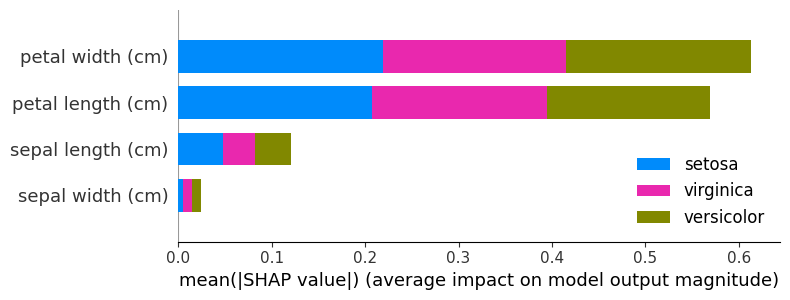

In [86]:
shap.summary_plot(shap_values,X_test.values, plot_type='bar', class_names=cn, feature_names=X_test.columns)

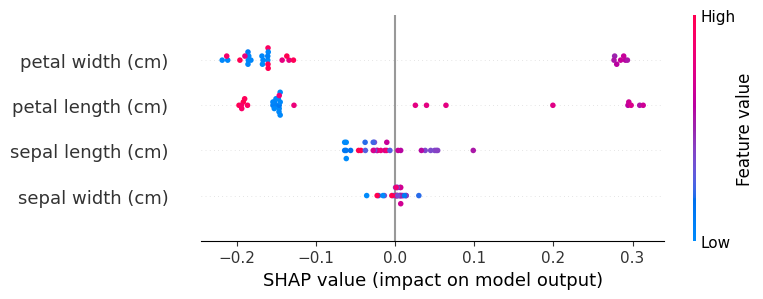

In [87]:
shap.summary_plot(shap_values[1],X_test.values,feature_names=X_test.columns)

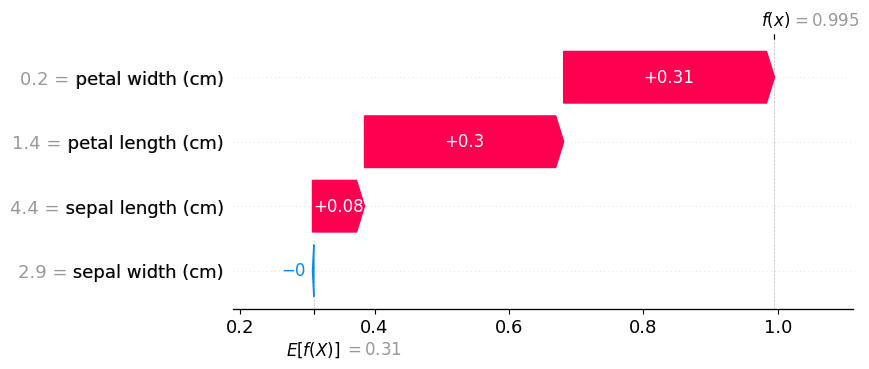

In [89]:
example=8
shap.waterfall_plot(shap.Explanation(values=shap_values[0][example],base_values=explainer.expected_value[0],data=X_test.iloc[example],
                                     feature_names=X_test.columns.to_list()))

Los valores de los cuadros explican porqué se definió como una clase 0, cuál fue el atributo que más aporto a esto, en este caso el petal

Entrenado con los dos mejores features.

In [92]:
rfc_2002col= RandomForestClassifier(n_estimators=200, random_state=0)
rfc_2002col.fit(X_train.iloc[:,2:],y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [98]:
predict_rf2002col= rfc_2002col.predict(X_test.iloc[:,2:])

In [99]:
print(classification_report(y_test,predict_rf2002col))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [100]:
rfc_2002col.score(X_test.iloc[:,2:],y_test)

1.0

In [101]:
estimado_tree = rfc_2002col.estimators_[5]

[Text(0.5, 0.9, 'petal width (cm) <= 0.8\ngini = 0.663\nsamples = 75\nvalue = [36, 46, 38]\nclass = versicolor'),
 Text(0.4230769230769231, 0.7, 'gini = 0.0\nsamples = 23\nvalue = [36, 0, 0]\nclass = setosa'),
 Text(0.5769230769230769, 0.7, 'petal width (cm) <= 1.65\ngini = 0.495\nsamples = 52\nvalue = [0, 46, 38]\nclass = versicolor'),
 Text(0.3076923076923077, 0.5, 'petal width (cm) <= 1.55\ngini = 0.085\nsamples = 29\nvalue = [0, 43, 2]\nclass = versicolor'),
 Text(0.15384615384615385, 0.3, 'petal length (cm) <= 5.25\ngini = 0.048\nsamples = 26\nvalue = [0, 40, 1]\nclass = versicolor'),
 Text(0.07692307692307693, 0.1, 'gini = 0.0\nsamples = 25\nvalue = [0, 40, 0]\nclass = versicolor'),
 Text(0.23076923076923078, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = virginica'),
 Text(0.46153846153846156, 0.3, 'petal length (cm) <= 5.45\ngini = 0.375\nsamples = 3\nvalue = [0, 3, 1]\nclass = versicolor'),
 Text(0.38461538461538464, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 3, 0]\

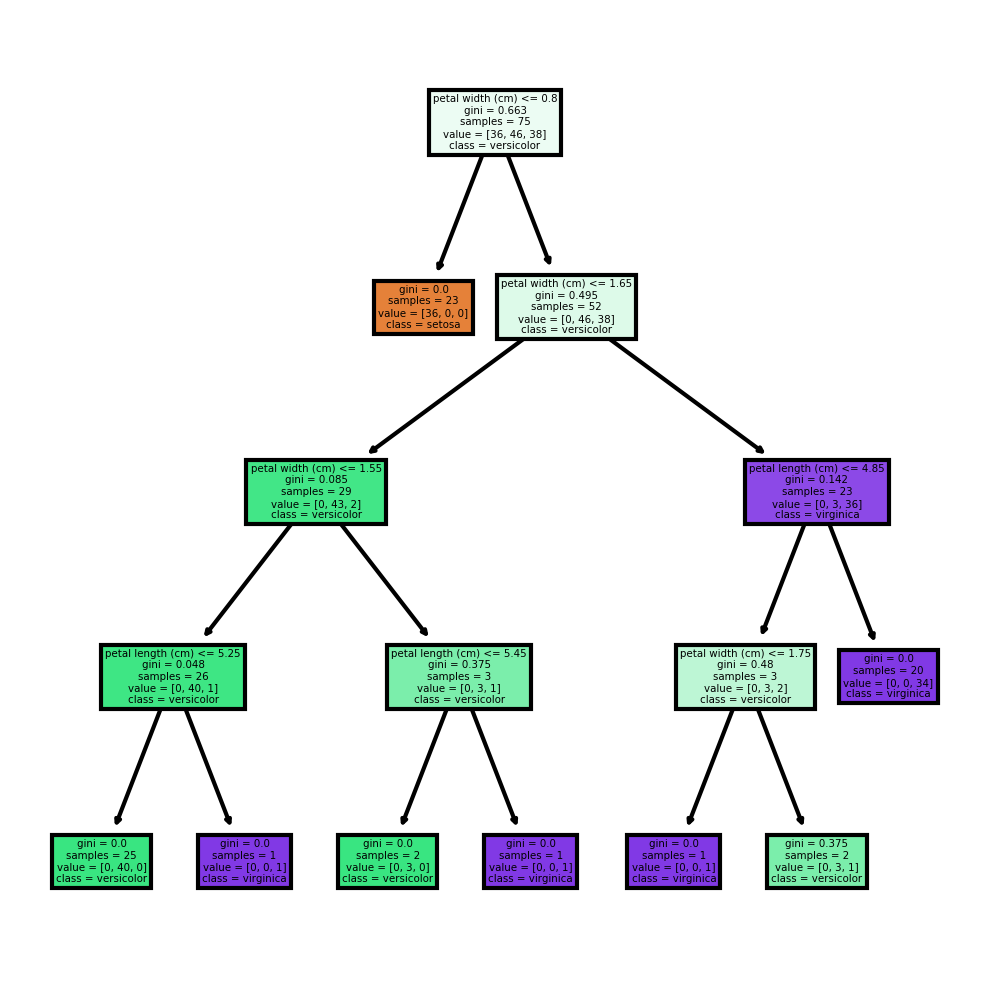

In [102]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
fn = features_num[1:]
cn = ['setosa', 'versicolor', 'virginica']
tree.plot_tree(estimado_tree, feature_names = fn, 
               class_names=cn,
               filled = True)

# stacking

In [5]:
from sklearn.ensemble import StackingClassifier #importamos

In [ ]:
#diccionario de tuplas
#definimos lo3  modleos 
base_learning= [
    ("rf", RandomForestClassifier(n_estimators=150) ), #primero es el random forest
    ("tree", tree.DecisionTreeClassifier() ) , #arbol de desicion
    ("nb", GaussianNB() ),  #Naive Bayes
]

stacking= StackingClassifier(estimators=base_learning,final_estimator=LogisticRegression(),cv=10) #final_estimator es el modelo final que pudimos logistc

In [105]:
stacking #este es el modelo ahora hagamos el pipeline

StackingClassifier(cv=10,
                   estimators=[('rf', RandomForestClassifier(n_estimators=150)),
                               ('tree', DecisionTreeClassifier()),
                               ('nb', GaussianNB())],
                   final_estimator=LogisticRegression())

In [106]:

stacking_pipeline = make_pipeline(
 preprocessor_union, #procesamiento de los datos
 stacking
)

In [107]:
stacking_pipeline #veamos como queda

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('robust_column',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('scaler numerical',
                                                 ColumnTransformer(transformers=[('transf. '
                                                                                  'num',
                                                                                  StandardScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('stackingclassifier',
                 StackingClassifier(cv=10,
                                    estimators=[('rf',
                                                 RandomForestClassifier(n_estimators=150)),
                                                ('tree',
                                                 DecisionTreeClassifier()),
                                                ('nb', GaussianNB())],
                                    final_estimator=LogisticRegression()))])

In [108]:
stacking_pipeline.fit(X_train,y_train) 

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('robust_column',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('scaler numerical',
                                                 ColumnTransformer(transformers=[('transf. '
                                                                                  'num',
                                                                                  StandardScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('stackingclassifier',
                 StackingClassifier(cv=10,
                                    estimators=[('rf',
                                                 RandomForestClassifier(n_estimators=150)),
                                                ('tree',
                                                 DecisionTreeClassifier()),
                                                ('nb', GaussianNB())],
                                    final_estimator=LogisticRegression()))])

In [109]:
predict_starcking= stacking_pipeline.predict(X_test) 

In [110]:
print(classification_report(y_test,predict_starcking))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92         6
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



In [111]:
 #hicimos eso en lo de staking 
 
 
 
### datos

 ### model1 model2 model3

 ## modelfinal

 #----------------------------------

 ##### datos

 ### model1 model2 model3

### model4 model5

 ### modelfinal

In [112]:

#los priemros 3 modelos

layer1= [
    ("rf", RandomForestClassifier(n_estimators=150) ),
    ("tree", tree.DecisionTreeClassifier() ) ,
    ("nb", GaussianNB() ),
]
#los ultimos 2
layer2 =[
    ("svm", svm.SVC()), # s epuede poner  otro modelo 
    ("lr",LogisticRegression())
]

modellayer2 = StackingClassifier(estimators=layer2,final_estimator=LogisticRegression(),cv=10)

modeltotal = StackingClassifier(estimators=layer1, final_estimator=modellayer2) #aqui ya unimos elmodelo bse que son los 3 modelo y el modelo final que son los 4 y 5 

In [ ]:
pipeline_stack2=make_pipeline(preprocessor_union,modeltotal) #correr

In [ ]:
pipeline_stack2   #coreer y veras que salke el proceso que realiza desde stacking_pipeline

In [113]:
modeltotal

StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=150)),
                               ('tree', DecisionTreeClassifier()),
                               ('nb', GaussianNB())],
                   final_estimator=StackingClassifier(cv=10,
                                                      estimators=[('svm',
                                                                   SVC()),
                                                                  ('lr',
                                                                   LogisticRegression())],
                                                      final_estimator=LogisticRegression()))

In [114]:
modeltotal.fit(X_train,y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=150)),
                               ('tree', DecisionTreeClassifier()),
                               ('nb', GaussianNB())],
                   final_estimator=StackingClassifier(cv=10,
                                                      estimators=[('svm',
                                                                   SVC()),
                                                                  ('lr',
                                                                   LogisticRegression())],
                                                      final_estimator=LogisticRegression()))

In [115]:
predictstacking2 =modeltotal.predict(X_test)

In [116]:
print(classification_report(y_test,predictstacking2 ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92         6
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



# Boosting

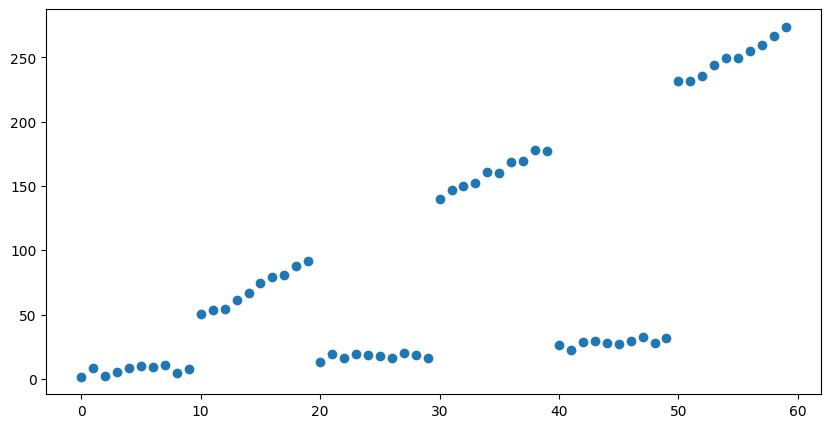

In [117]:
x1 = np.arange(0, 60)
y1 = map(lambda x1: x1 / 2 + (x1 // 10) % 2 * 20 * x1 / 5 + np.random.random() * 10, x1)
df = pd.DataFrame({'x': x1,'y': y1})
X=df[["x"]]
y = df.y

# Plot mock data
plt.figure(figsize=(10, 5))
plt.scatter(X, df.y)
plt.show()

In [118]:
from sklearn.ensemble import GradientBoostingRegressor

In [119]:
params= {
"n_estimators": 3,
'max_depth':1,
'learning_rate':1,
'criterion': 'squared_error'
}

gboost= GradientBoostingRegressor(**params)
gboost.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=1, n_estimators=3)

c:\Users\javier\miniconda3\envs\py10\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\javier\miniconda3\envs\py10\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names


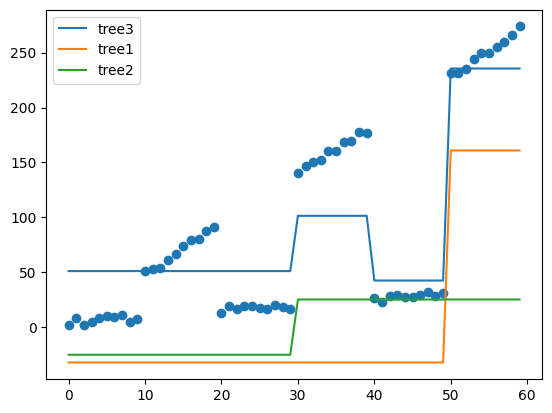

In [120]:
plt.scatter(X,y)
plt.plot(X,gboost.predict(X),label="tree3")
plt.plot(X,gboost.estimators_[0][0].predict(X),label="tree1") # que solo tome el priemr alrbol de desicion
plt.plot(X,gboost.estimators_[1][0].predict(X),label="tree2") #segundo arbol de desicion 
plt.legend()

cada arbol intenta mejorar el anterior.

ahora si tenemos avrios arboles no solo 3

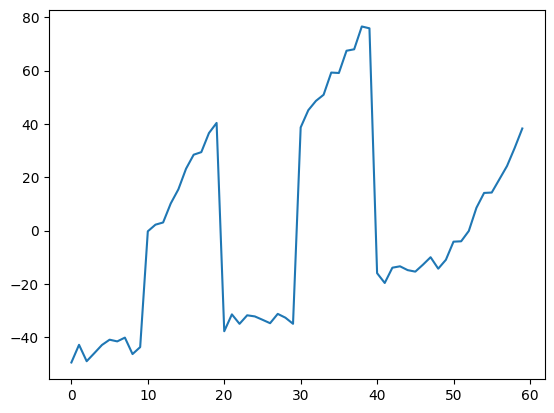

In [121]:
plt.plot(X, y-gboost.predict(X))

[Text(0.5, 0.75, 'x <= 49.5\nfriedman_mse = 7895.87\nsamples = 60\nvalue = 0.0'),
 Text(0.25, 0.25, 'friedman_mse = 3223.087\nsamples = 50\nvalue = -32.182'),
 Text(0.75, 0.25, 'friedman_mse = 189.298\nsamples = 10\nvalue = 160.91')]

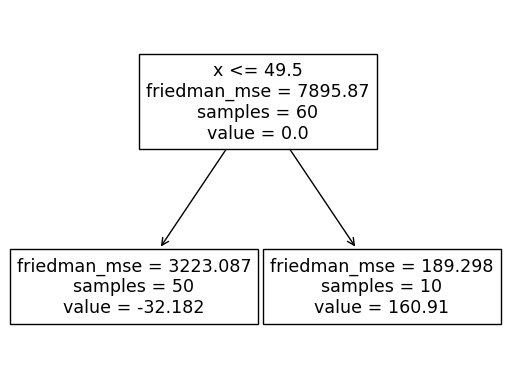

In [125]:
tree_boosting = gboost.estimators_[0][0]
tree.plot_tree(tree_boosting, feature_names=["x"], class_names=["y"])

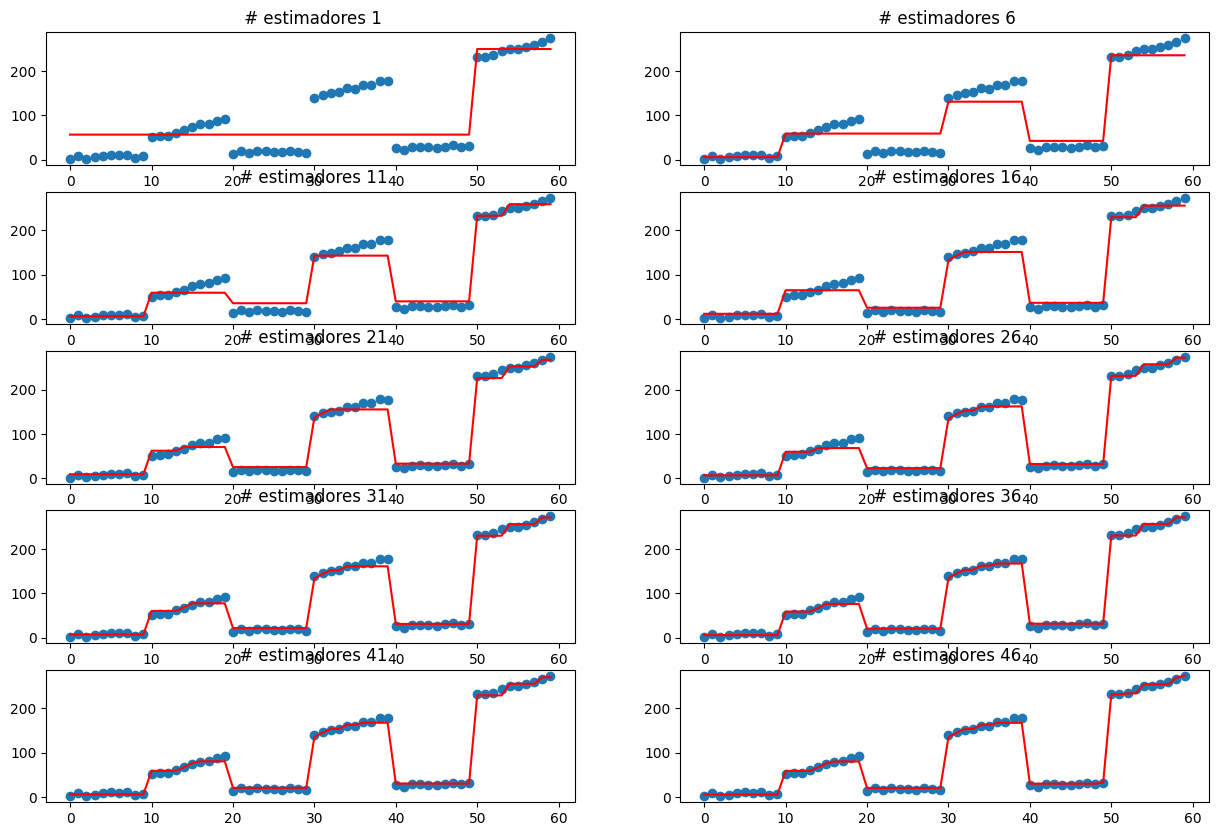

In [126]:
f ,ax =plt.subplots(5,2, figsize=(15,10) )
for idx, n_est in enumerate(range(1,50, 5)):
    params["n_estimators"]=n_est
    gboost =GradientBoostingRegressor(**params)
    gboost.fit(X,y)
    subplot =ax[idx//2][idx % 2]
    subplot.set_title(f" # estimadores {n_est}")
    subplot.scatter(X,y)
    subplot.plot(X,gboost.predict(X), color='r')

In [127]:
from sklearn.ensemble import AdaBoostClassifier
adam =AdaBoostClassifier(n_estimators=3)
adam.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=3)

 # XGboost
https://xgboost.readthedocs.io/en/stable/

In [128]:
#!pip install xgboost
import xgboost as xgb

In [129]:
xgb_model= xgb.XGBClassifier(objective="multi:softprob")
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [130]:
xgb_model.score(X_test,y_test)

0.9666666666666667

In [131]:
from sklearn.model_selection import StratifiedKFold

In [132]:
xgb_class= xgb.XGBClassifier()

In [133]:
params= {
  "objective":["multi:softprob"],
  "eval_metric":["auc"],
  "max_depth":[1,3],
  "early_stopping_rounds":[5],
  "learning_rate": [0.01,0.1],
  "n_estimators":[100]
}

GXB= GridSearchCV(estimator=xgb_class, param_grid=params,cv=3,scoring='accuracy',verbose=1)

In [134]:
GXB.fit(X_train,y_train, eval_set=[(X_train,y_train), (X_test,y_test)])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[0]	validation_0-auc:0.97768	validation_1-auc:0.99057
[1]	validation_0-auc:0.97768	validation_1-auc:0.99057
[2]	validation_0-auc:0.97768	validation_1-auc:0.99057
[3]	validation_0-auc:0.97768	validation_1-auc:0.99057
[4]	validation_0-auc:0.97768	validation_1-auc:0.99057
[0]	validation_0-auc:0.95967	validation_1-auc:0.99057
[1]	validation_0-auc:0.95967	validation_1-auc:0.99057
[2]	validation_0-auc:0.95967	validation_1-auc:0.99057
[3]	validation_0-auc:0.95967	validation_1-auc:0.99057
[4]	validation_0-auc:0.95967	validation_1-auc:0.99057
[5]	validation_0-auc:0.95967	validation_1-auc:0.99057
[0]	validation_0-auc:0.97822	validation_1-auc:0.97328
[1]	validation_0-auc:0.97822	validation_1-auc:0.97328
[2]	validation_0-auc:0.97822	validation_1-auc:0.97328
[3]	validation_0-auc:0.97822	validation_1-auc:0.97328
[4]	validation_0-auc:0.97822	validation_1-auc:0.97328
[5]	validation_0-auc:0.98480	validation_1-auc:0.98586
[6]	validation_0-auc:0

[0]	validation_0-auc:0.98380	validation_1-auc:0.99843
[1]	validation_0-auc:0.98380	validation_1-auc:0.99843
[2]	validation_0-auc:0.98380	validation_1-auc:0.99843
[3]	validation_0-auc:0.98380	validation_1-auc:0.99843
[4]	validation_0-auc:0.98380	validation_1-auc:0.99843
[5]	validation_0-auc:0.98380	validation_1-auc:0.99843
[0]	validation_0-auc:0.98480	validation_1-auc:0.98586
[1]	validation_0-auc:0.98480	validation_1-auc:0.98586
[2]	validation_0-auc:0.98480	validation_1-auc:0.98586
[3]	validation_0-auc:0.98480	validation_1-auc:0.98586
[4]	validation_0-auc:0.98480	validation_1-auc:0.98586
[0]	validation_0-auc:0.97768	validation_1-auc:0.99057
[1]	validation_0-auc:0.97768	validation_1-auc:0.99057
[2]	validation_0-auc:0.98130	validation_1-auc:0.99057
[3]	validation_0-auc:0.99756	validation_1-auc:0.99843
[4]	validation_0-auc:0.99798	validation_1-auc:0.99843
[5]	validation_0-auc:0.99798	validation_1-auc:0.99843
[6]	validation_0-auc:0.99788	validation_1-auc:0.99843
[7]	validation_0-auc:0.99788

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'early_stopping_rounds': [5], 'eval_metric': ['auc'],
                         'learning_rate': [0.01, 0.1], 'max_depth': [1, 3],
                         'n_estimators': [100],
                         'objective': ['multi:softprob']},
             scoring='accuracy', verbose=1)

In [135]:
GXB.best_params_

{'early_stopping_rounds': 5,
 'eval_metric': 'auc',
 'learning_rate': 0.01,
 'max_depth': 1,
 'n_estimators': 100,
 'objective': 'multi:softprob'}

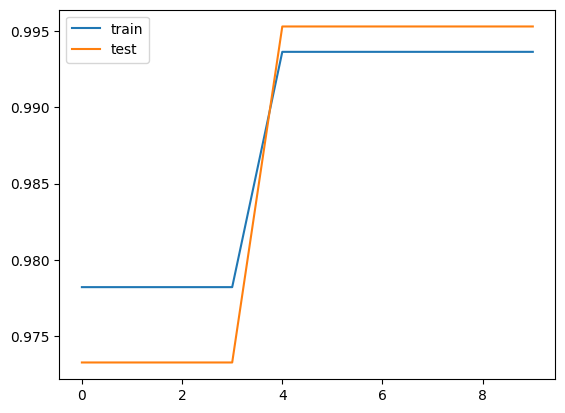

In [136]:
plt.plot(GXB.best_estimator_.evals_result()["validation_0"]["auc"], label='train')
plt.plot(GXB.best_estimator_.evals_result()["validation_1"]["auc"], label='test')
plt.legend()

In [137]:
GXB.best_estimator_.evals_result()

{'validation_0': OrderedDict([('auc',
               [0.9782156974225688,
                0.9782156974225688,
                0.9782156974225688,
                0.9782156974225688,
                0.9936241065627031,
                0.9936241065627031,
                0.9936241065627031,
                0.9936241065627031,
                0.9936241065627031,
                0.9936241065627031])]),
 'validation_1': OrderedDict([('auc',
               [0.9732821637426899,
                0.9732821637426899,
                0.9732821637426899,
                0.9732821637426899,
                0.9952850877192981,
                0.9952850877192981,
                0.9952850877192981,
                0.9952850877192981,
                0.9952850877192981,
                0.9952850877192981])])}

In [138]:
#!pip install mlflow

In [140]:
import mlflow